In [1]:
# author: Zhuocheng Sun, Yueyu Wang
# instructor: Tyler Caraza-Harter

from shapely.geometry import Point, Polygon
import shapefile as shp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import contextily as ctx
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [5]:
df = pd.read_csv("apartments.csv")
pts_col = []

# df = df[df["PropertyClass"] == "Residential"]

for pt in df[["XCoord", "YCoord"]].itertuples():
    pts_col.append(Point(pt.XCoord, pt.YCoord))
df["geometry"] = pts_col
df = df[["Address", "PropertyUse", "PropertyClass", "Bedrooms", "geometry", "XCoord", "YCoord"]]

# df["Bedrooms"] = df["Bedrooms"]  + 0.01 # add a small value to handle 0 bedroom cases.
df = gpd.GeoDataFrame(df)
df = df.set_crs("esri:103412")
df = df.to_crs(epsg=4326)

df = df[["Address", "PropertyUse", "PropertyClass", "Bedrooms", "geometry", "XCoord", "YCoord"]]
df.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (42,43,104,109,122) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord
0,2333 Carling Dr Unit 4,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813
1,2337 Carling Dr Unit 1,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813
2,2337 Carling Dr Unit 2,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813
3,2337 Carling Dr Unit 3,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813
4,2337 Carling Dr Unit 4,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813


### Generally, 18 year-olds could be either 12th-grade students or college freshmen. Since we found many data entries with majorities of 18-19 year-olds, and many of those properties are located near UW campus, we think it makes more sense to regard them as college students rather than 12th-grade students. Thus, for simplicity, we only count 5 to 17 year-olds as K-12 student in this notebook.

In [6]:
census_df = pd.read_csv("census_by_block_2010/sex_age.csv")
census_df["GEO_ID"] = census_df["GEO_ID"]
census_df = census_df[["GEO_ID", "NAME", "P012001", "P012004", "P012005", "P012006", "P012028", "P012029", "P012030"]]
census_df = census_df.rename(columns = {"NAME":"Area", "P012001": "Total_people", "P012004": "5-9yrMale", "P012005": "10-14yrMale", "P012006": "15-17yrMale", "P012028": "5-9yrFemale", "P012029": "10-14yrFemale", "P012030": "15-17yrFemale"}, inplace=False)
census_df = census_df[1:]
census_df["Total_people"] = census_df["Total_people"].astype(int)
census_df["5-9yr"] = census_df["5-9yrMale"].astype(int) + census_df["5-9yrFemale"].astype(int)
census_df["10-14yr"] = census_df["10-14yrMale"].astype(int) + census_df["10-14yrFemale"].astype(int)
census_df["15-17yr"] = census_df["15-17yrMale"].astype(int) + census_df["15-17yrFemale"].astype(int)

census_df["Total_K-12_block"] = census_df["5-9yr"] + census_df["10-14yr"] + census_df["15-17yr"]
census_df = census_df[census_df["Total_K-12_block"] != 0]
census_df.head()

,GEO_ID,Area,Total_people,5-9yrMale,10-14yrMale,15-17yrMale,5-9yrFemale,10-14yrFemale,15-17yrFemale,5-9yr,10-14yr,15-17yr,Total_K-12_block
1,1000000US550250001001000,"Block 1000, Block Group 1, Census Tract 1, Dan...",170,1,3,1,1,7,4,2,10,5,17
2,1000000US550250001001001,"Block 1001, Block Group 1, Census Tract 1, Dan...",23,1,0,2,0,0,1,1,0,3,4
4,1000000US550250001001003,"Block 1003, Block Group 1, Census Tract 1, Dan...",38,1,1,0,0,1,3,1,2,3,6
5,1000000US550250001001004,"Block 1004, Block Group 1, Census Tract 1, Dan...",141,4,7,4,6,4,3,10,11,7,28
7,1000000US550250001001006,"Block 1006, Block Group 1, Census Tract 1, Dan...",38,1,0,3,0,6,0,1,6,3,10


In [8]:
# spatial join - take dataset A + dataset B = dataset AB, based on space/geographic relationship
# two datasets must have a matched CRS: coordinate reference system

dane = gpd.read_file("newdane/newdane.shp")
dane["GEO_ID"] = "1000000US" + dane["GEOID10"]
dane.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,GEO_ID
0,55,025,000504,4022,550250005044022,Block 4022,G5040,U,53200,U,S,29724,0,+43.0201083,-089.5332753,"POLYGON ((-89.53341 43.02386, -89.53338 43.024...",1000000US550250005044022
1,55,025,011402,2035,550250114022035,Block 2035,G5040,U,53200,U,S,966914,0,+43.1459496,-089.2952544,"POLYGON ((-89.30400 43.15012, -89.29644 43.148...",1000000US550250114022035
2,55,025,011402,2055,550250114022055,Block 2055,G5040,U,53200,U,S,424,0,+43.1371818,-089.2960596,"POLYGON ((-89.29621 43.13719, -89.29602 43.137...",1000000US550250114022055
3,55,025,011401,3028,550250114013028,Block 3028,G5040,U,53200,U,S,27367,0,+43.0793222,-089.2820008,"POLYGON ((-89.28349 43.08452, -89.28278 43.082...",1000000US550250114013028
4,55,025,010901,1102,550250109011102,Block 1102,G5040,U,53200,U,S,23669,0,+43.0739416,-089.5306223,"POLYGON ((-89.53099 43.07488, -89.52984 43.074...",1000000US550250109011102


In [9]:
dane.to_crs(df.crs, inplace=True)
dane['area'] = dane.to_crs(epsg=3857).area/2.59e+06
block_with_apartment = gpd.sjoin(df, dane, how="left", op="within")
block_with_apartment = block_with_apartment[['Address', 'PropertyUse', 'PropertyClass', 'Bedrooms','geometry', "XCoord", "YCoord",  'GEO_ID', 'area']]
block_with_apartment.head()

,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,GEO_ID,area
0,2333 Carling Dr Unit 4,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813,1000000US550250006003000,0.025992
1,2337 Carling Dr Unit 1,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813,1000000US550250006003000,0.025992
2,2337 Carling Dr Unit 2,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813,1000000US550250006003000,0.025992
3,2337 Carling Dr Unit 3,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813,1000000US550250006003000,0.025992
4,2337 Carling Dr Unit 4,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813,1000000US550250006003000,0.025992


#### We now have census data for each block in Madison. To estimate the number of K-12 students in each property, we think using the formula: K-12_est = (number of bedrooms in a property) * (number of K-12 students in the block)/ (number of bedrooms in the block) is a good approach for now.

In [10]:
merged = pd.merge(block_with_apartment, census_df, on="GEO_ID", how='inner')
merged = merged[["Area","Address", "PropertyUse", "PropertyClass", "Bedrooms", "geometry", "XCoord", "YCoord", "Total_people", "Total_K-12_block", "GEO_ID", "area"]]
merged['BlockBedrooms'] = merged.groupby(['GEO_ID']).Bedrooms.transform('sum')
merged.head()

,Area,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,Total_people,Total_K-12_block,GEO_ID,area,BlockBedrooms
0,"Block 3000, Block Group 3, Census Tract 6, Dan...",2333 Carling Dr Unit 4,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813,197,46,1000000US550250006003000,0.025992,77
1,"Block 3000, Block Group 3, Census Tract 6, Dan...",2337 Carling Dr Unit 1,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813,197,46,1000000US550250006003000,0.025992,77
2,"Block 3000, Block Group 3, Census Tract 6, Dan...",2337 Carling Dr Unit 2,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813,197,46,1000000US550250006003000,0.025992,77
3,"Block 3000, Block Group 3, Census Tract 6, Dan...",2337 Carling Dr Unit 3,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813,197,46,1000000US550250006003000,0.025992,77
4,"Block 3000, Block Group 3, Census Tract 6, Dan...",2337 Carling Dr Unit 4,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813,197,46,1000000US550250006003000,0.025992,77


In [11]:
merged["K12_est"] = merged["Total_K-12_block"] * merged["Bedrooms"] / merged["BlockBedrooms"]
K12_df = merged
K12_df.head()

,Area,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,Total_people,Total_K-12_block,GEO_ID,area,BlockBedrooms,K12_est
0,"Block 3000, Block Group 3, Census Tract 6, Dan...",2333 Carling Dr Unit 4,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813,197,46,1000000US550250006003000,0.025992,77,1.194805
1,"Block 3000, Block Group 3, Census Tract 6, Dan...",2337 Carling Dr Unit 1,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813,197,46,1000000US550250006003000,0.025992,77,1.194805
2,"Block 3000, Block Group 3, Census Tract 6, Dan...",2337 Carling Dr Unit 2,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813,197,46,1000000US550250006003000,0.025992,77,1.194805
3,"Block 3000, Block Group 3, Census Tract 6, Dan...",2337 Carling Dr Unit 3,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813,197,46,1000000US550250006003000,0.025992,77,1.194805
4,"Block 3000, Block Group 3, Census Tract 6, Dan...",2337 Carling Dr Unit 4,Condominium,Residential,2,POINT (-89.46093 43.02791),800650.916687,465776.525813,197,46,1000000US550250006003000,0.025992,77,1.194805


In [12]:
lake_df = gpd.read_file("lakes.zip")

Text(0.5, 1.0, 'Figure 1: Number of K-12 students in Madison per census block')

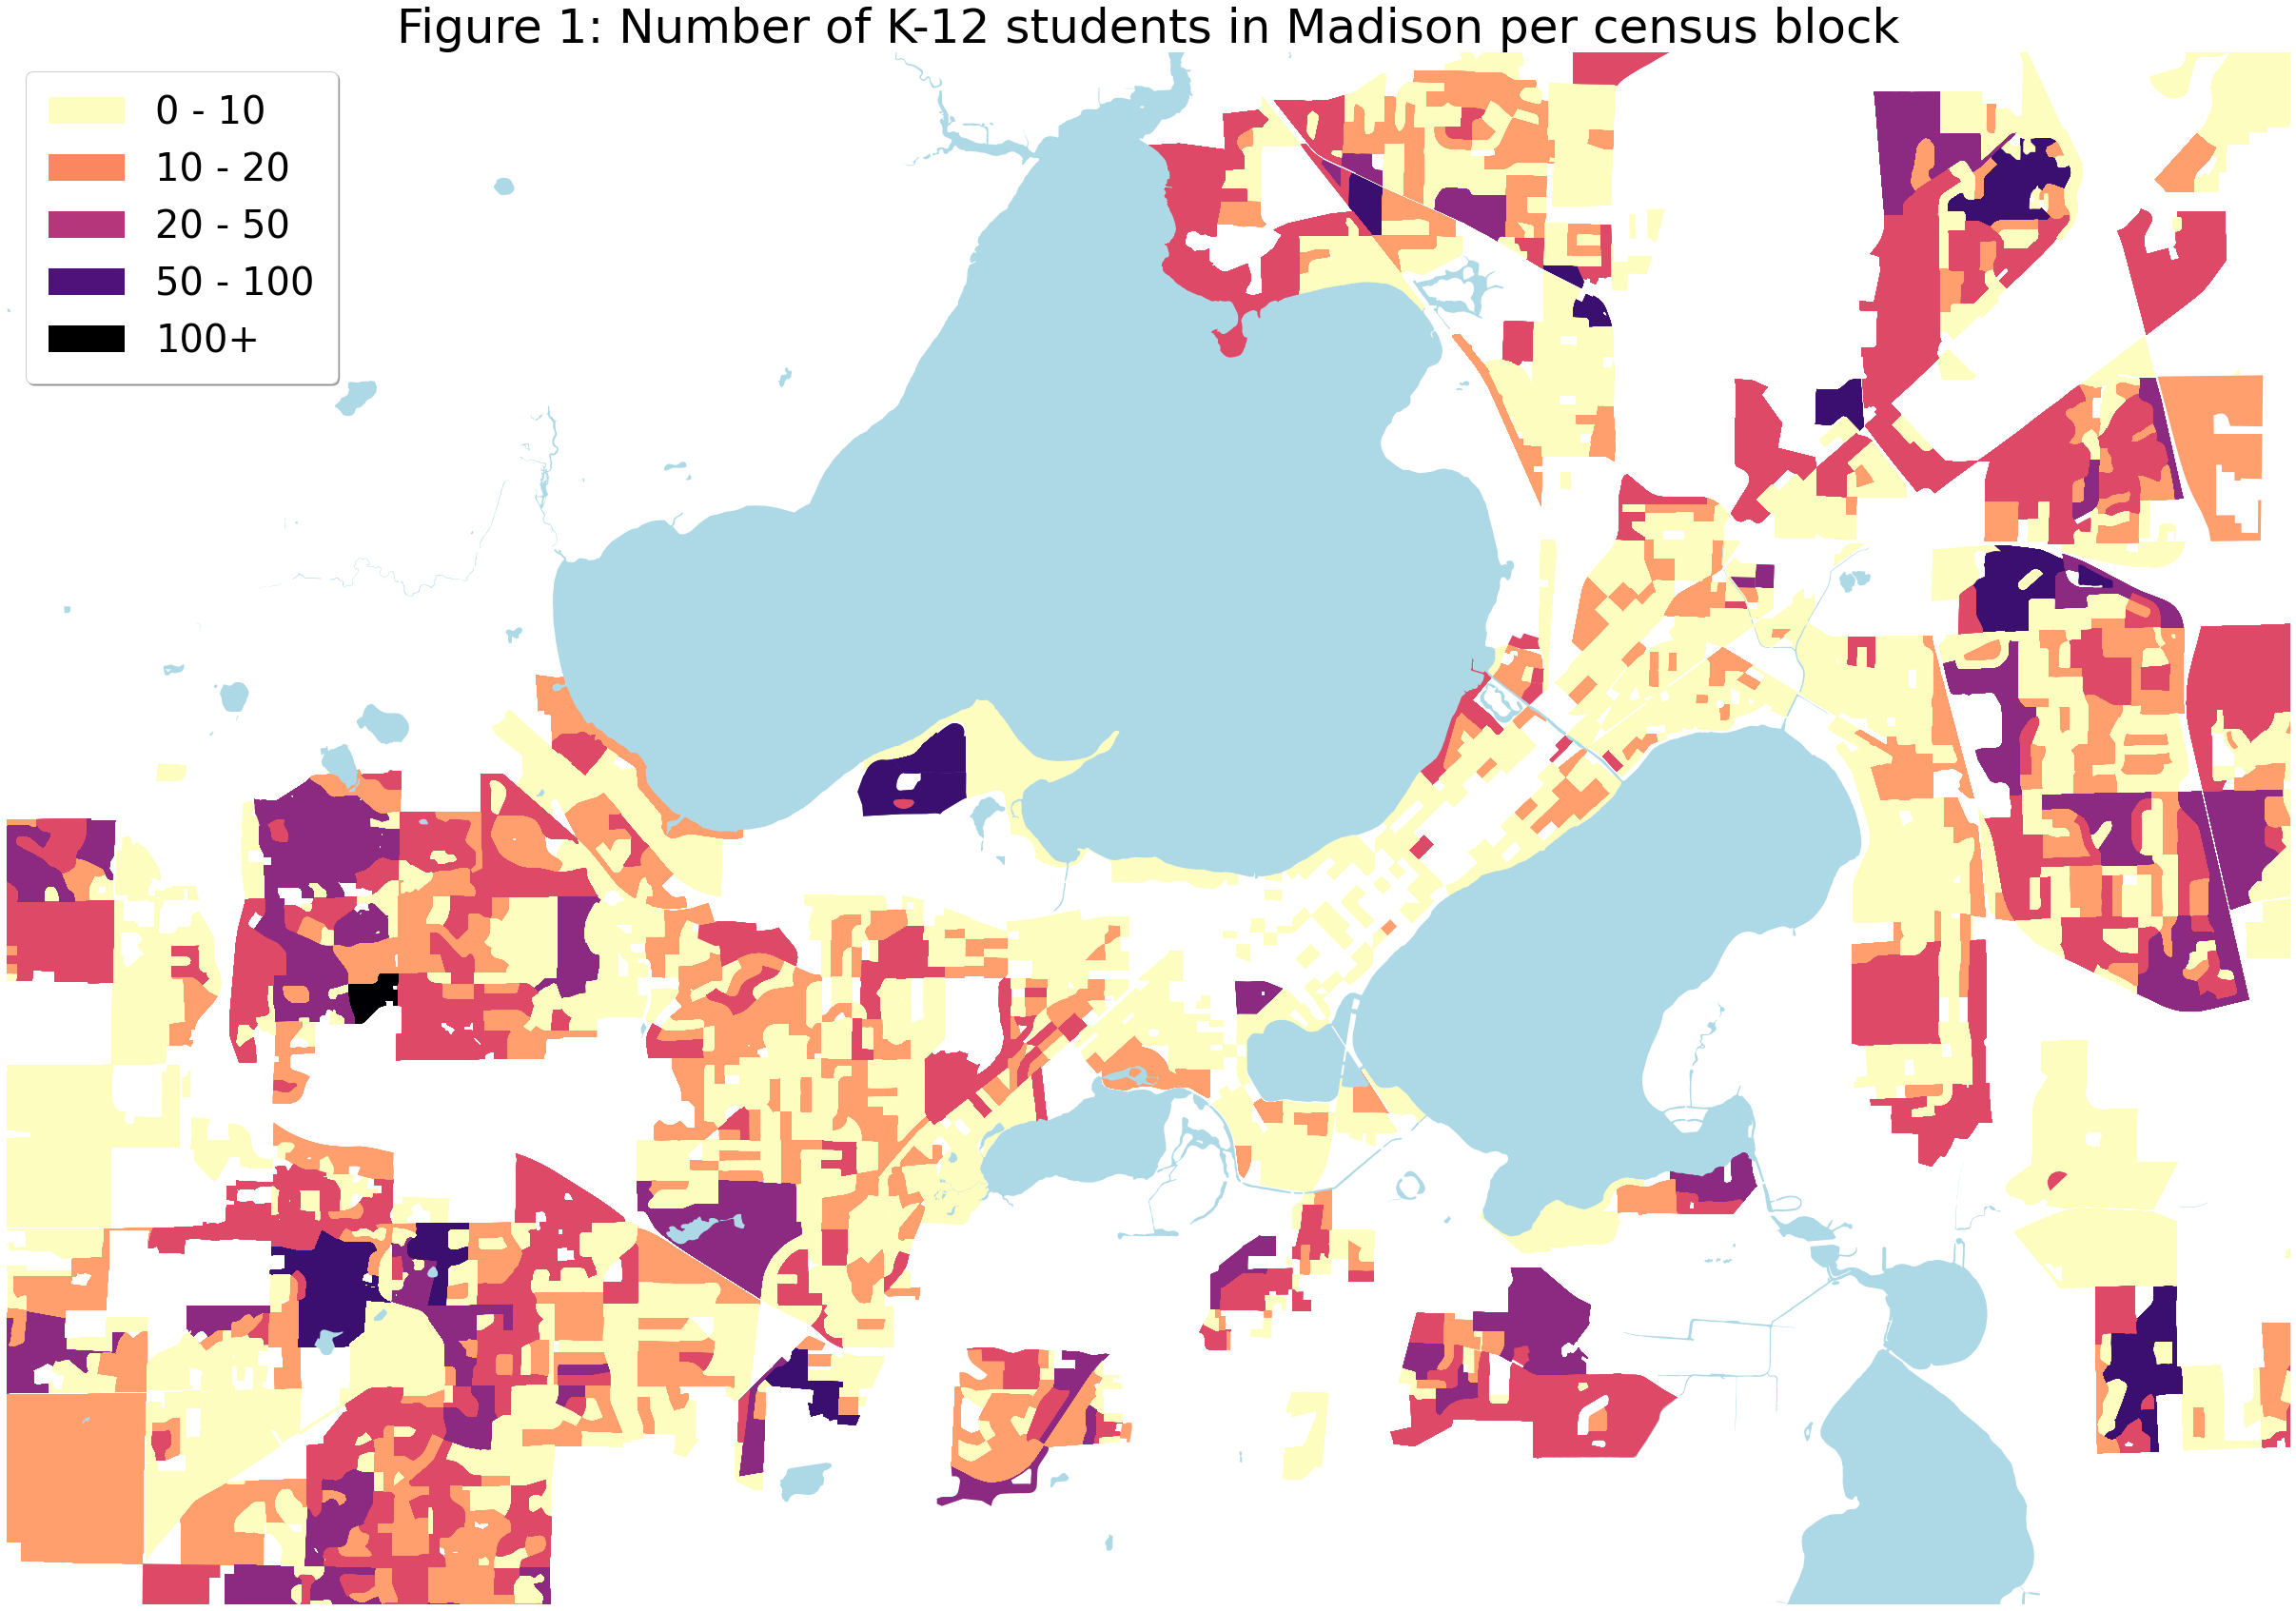

In [13]:
import matplotlib.patches as mpatches
import mapclassify as mc

madison = gpd.sjoin(K12_df, dane, how="right", op="within")
madison = madison[madison["Total_K-12_block"] >= 0]
bp = mc.UserDefined(madison["Total_K-12_block"], bins=[10, 20, 50, 100, 150])
ax = madison.plot(figsize = (50, 30), legend=True, scheme = 'UserDefined',
                  classification_kwds={'bins': [10, 20, 50, 100, 150]},
                  k = 5, column='Total_K-12_block', cmap = 'magma_r')
lake_df.plot(ax=ax,color="lightblue")
handles, labels = ax.get_legend_handles_labels()
cmap = plt.get_cmap('magma_r')
bins = bp.bins
bins = np.insert(bins, 0, 0)
LegendElement = [mpatches.Patch(facecolor=cmap(_*0.25), label=f'{int(max(bins[_], 0))} - {int(bins[_+1])}')
                 for _ in range(4)] + [mpatches.Patch(facecolor='black', hatch='', label='100+')]
ax.legend(handles = LegendElement, loc='upper left', fontsize=40, shadow=True, borderpad=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.0125, 43.150])
ax.set_xlim([-89.55, -89.273])
ax.axis('off')
ax.set_title("Figure 1: Number of K-12 students in Madison per census block", fontsize = 50)

## Linear Regression part

In [9]:
Condominium_bedroom_block = merged[(merged["PropertyUse"] == "Condominium") | (merged["PropertyUse"] == "2 unit Apartment")
                                   | (merged["PropertyUse"] == "3 unit Apartment") | (merged["PropertyUse"] == "4 unit Apartment")
                                   | (merged["PropertyUse"] == "5 unit Apartment") | (merged["PropertyUse"] == "6 unit Apartment")
                                   | (merged["PropertyUse"] == "7 unit Apartment")]
Condominium_bedroom_block = Condominium_bedroom_block[["Area", "Address", "PropertyUse", "Bedrooms", "Total_K-12_block", "GEO_ID", "BlockBedrooms", "geometry", "area"]]
Condominium_bedroom_block["Apartment_bedroom"] = Condominium_bedroom_block.groupby(['GEO_ID']).Bedrooms.transform('sum')
Condominium_bedroom_block["other_bedroom"] = Condominium_bedroom_block["BlockBedrooms"] - Condominium_bedroom_block["Apartment_bedroom"]
Condominium_bedroom_block = Condominium_bedroom_block.drop_duplicates("GEO_ID")
Condominium_bedroom_block = Condominium_bedroom_block[["GEO_ID", "Apartment_bedroom", "other_bedroom"]]
total_bedroom_block = merged[["GEO_ID", "BlockBedrooms", "Total_K-12_block", "geometry", "area"]]
total_bedroom_block = total_bedroom_block.drop_duplicates("GEO_ID")
result = total_bedroom_block.merge(Condominium_bedroom_block, on="GEO_ID", how = "outer")
result["Apartment_bedroom"].fillna(0, inplace=True)
result["other_bedroom"].fillna(result["BlockBedrooms"], inplace=True)
result["BlockBedrooms"].sum()

111946.41999999995

1.483143753902602


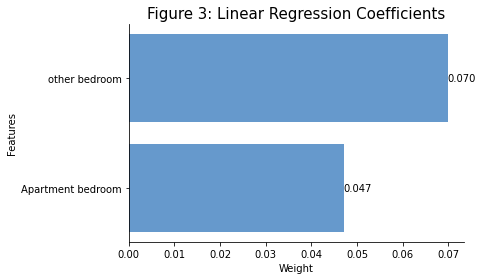

In [10]:
xcol = ["Apartment_bedroom", "other_bedroom"]
model1 = Pipeline([
            ("lr", LinearRegression())
        ])
model1.fit(result[xcol], result["Total_K-12_block"])

idx = [t.replace("_", " ") for t in xcol]
fig, ax = plt.subplots()
ax3 = ax.barh(range(len(idx)), model1["lr"].coef_, color='#6699CC')
for rect in ax3:
    w = rect.get_width()
    ax.text(w, rect.get_y()+rect.get_height()/2,
            "%.3f" % w, ha='left', va='center')
ax.set_yticks(range(len(idx)))
ax.set_yticklabels(idx)
ax.set_xlabel("Weight")
ax.set_ylabel("Features")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Figure 3: Linear Regression Coefficients", fontsize=15)
print(model1["lr"].coef_[1] / model1["lr"].coef_[0])

## Top 20 apartments table

In [11]:
# sort by the number of K-12 children estimation grouped by Point.
K12_df["K-12_by_point"] = K12_df.groupby(by=["XCoord", "YCoord"])["K12_est"].transform('sum')
point_order = K12_df.sort_values(by=['K-12_by_point'], ascending=False)

In [12]:
Top_70 = K12_df
Top_70 = Top_70[(Top_70["PropertyUse"] == "Condominium") | (Top_70["PropertyUse"] == "2 unit Apartment")
                                   | (Top_70["PropertyUse"] == "3 unit Apartment") | (Top_70["PropertyUse"] == "4 unit Apartment")
                                   | (Top_70["PropertyUse"] == "5 unit Apartment") | (Top_70["PropertyUse"] == "6 unit Apartment")
                                   | (Top_70["PropertyUse"] == "7 unit Apartment")]
Top_70["Apartment_bedrooms"] = Top_70.groupby(["XCoord", "YCoord"]).Bedrooms.transform(sum)
Top_70 = Top_70.drop_duplicates("geometry")
Top_70 = Top_70.sort_values(by=['K-12_by_point'], ascending=False)
Top_70 = Top_70[:70]
Top_70 = Top_70[["Area", "Address", "geometry", "Apartment_bedrooms", "K-12_by_point", "XCoord", "YCoord", "GEO_ID"]]
total_70 = Top_70[["Address", "Apartment_bedrooms", "K-12_by_point"]]
total_70.to_csv("Top70_Apartments.csv", index = False)
Top_70

/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,Area,Address,geometry,Apartment_bedrooms,K-12_by_point,XCoord,YCoord,GEO_ID
26865,"Block 2008, Block Group 2, Census Tract 2.05, ...",7318 Old Sauk Rd,POINT (-89.51222 43.07606),298.29,68.000000,786954.418390,483340.753717,1000000US550250002052008
0,"Block 2003, Block Group 2, Census Tract 6, Dan...",2333 Carling Dr Unit 4,POINT (-89.46093 43.02791),77.39,43.137021,800650.916687,465776.525813,1000000US550250006002003
14067,"Block 2002, Block Group 2, Census Tract 14.01,...",1141 Petra Pl Unit 2,POINT (-89.40292 43.03639),64.33,40.073314,816161.934738,468868.082844,1000000US550250014012002
36155,"Block 2010, Block Group 2, Census Tract 26.02,...",4310 Melody Ln Unit 101,POINT (-89.30960 43.13227),465.89,36.000000,841065.940057,503834.330672,1000000US550250026022010
40,"Block 2003, Block Group 2, Census Tract 6, Dan...",2354 Allied Dr Unit 2,POINT (-89.46006 43.02748),64.33,35.857405,800883.479732,465621.146628,1000000US550250006002003
...,...,...,...,...,...,...,...,...
27542,"Block 3002, Block Group 3, Census Tract 5.01, ...",5837 Raymond Rd,POINT (-89.48281 43.03156),12.01,4.588222,794800.572244,467111.070535,1000000US550250005013002
3477,"Block 1005, Block Group 1, Census Tract 26.02,...",3102 Old Gate Rd Unit 1,POINT (-89.32038 43.13579),14.04,4.575537,838187.235221,505115.808756,1000000US550250026021005
34956,"Block 2011, Block Group 2, Census Tract 4.07, ...",1049 McKenna Blvd,POINT (-89.50434 43.04188),16.17,4.561480,789048.660110,470877.260264,1000000US550250004072011
34992,"Block 2011, Block Group 2, Census Tract 4.07, ...",1109 McKenna Blvd Unit E,POINT (-89.50440 43.04109),16.09,4.538913,789030.119642,470592.074205,1000000US550250004072011


In [13]:
Top_70 = Top_70.reset_index()
Top_70 = Top_70[["Address", "GEO_ID", "Apartment_bedrooms", "K-12_by_point", "geometry"]]

In [29]:
Top_70.iloc[47]

Address                                               7813 Tree Ln
GEO_ID                                    1000000US550250002043007
Apartment_bedrooms                                          127.62
K-12_by_point                                                  6.0
geometry              POINT (-89.51861807300318 43.06325694473291)
Name: 47, dtype: object

In [30]:
pd.set_option('display.max_rows', None)
block_with_apartment[block_with_apartment["GEO_ID"] == "1000000US550250002043007"]

,Address,PropertyUse,Bedrooms,geometry,XCoord,YCoord,GEO_ID,area
55434,7813 Tree Ln,Condominium,2.01,POINT (-89.51862 43.06326),785239.121964,478674.375552,1000000US550250002043007,0.011194
55435,7815 Tree Ln,Condominium,2.01,POINT (-89.51862 43.06326),785239.121964,478674.375552,1000000US550250002043007,0.011194
55436,7801 Tree Ln,Condominium,2.01,POINT (-89.51862 43.06326),785239.121964,478674.375552,1000000US550250002043007,0.011194
55437,7803 Tree Ln,Condominium,3.01,POINT (-89.51862 43.06326),785239.121964,478674.375552,1000000US550250002043007,0.011194
55438,7805 Tree Ln,Condominium,2.01,POINT (-89.51862 43.06326),785239.121964,478674.375552,1000000US550250002043007,0.011194
55439,7807 Tree Ln,Condominium,2.01,POINT (-89.51862 43.06326),785239.121964,478674.375552,1000000US550250002043007,0.011194
55440,202 S High Point Rd,Condominium,3.01,POINT (-89.51862 43.06326),785239.121964,478674.375552,1000000US550250002043007,0.011194
55441,204 S High Point Rd,Condominium,2.01,POINT (-89.51862 43.06326),785239.121964,478674.375552,1000000US550250002043007,0.011194
55442,206 S High Point Rd,Condominium,2.01,POINT (-89.51862 43.06326),785239.121964,478674.375552,1000000US550250002043007,0.011194
55443,208 S High Point Rd,Condominium,2.01,POINT (-89.51862 43.06326),785239.121964,478674.375552,1000000US550250002043007,0.011194


## Plots

#### cumulative children live in apartments

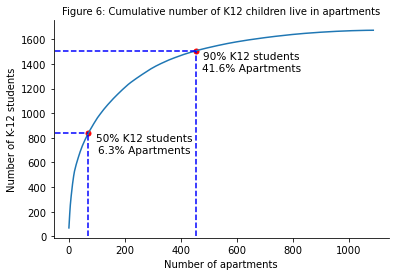

In [17]:
Buildings = K12_df[["GEO_ID", "PropertyUse", "geometry", "Area", "K-12_by_point"]]
Buildings = Buildings[(Buildings["PropertyUse"] == "Condominium") | (Buildings["PropertyUse"] == "2 unit Apartment")
                                   | (Buildings["PropertyUse"] == "3 unit Apartment") | (Buildings["PropertyUse"] == "4 unit Apartment")
                                   | (Buildings["PropertyUse"] == "5 unit Apartment") | (Buildings["PropertyUse"] == "6 unit Apartment")
                                   | (Buildings["PropertyUse"] == "7 unit Apartment")]
Buildings = Buildings.drop_duplicates("geometry")
Buildings = Buildings.sort_values(by=['K-12_by_point'], ascending=False)
K12_data = np.array(Buildings["K-12_by_point"].tolist())
cumulative = pd.DataFrame(K12_data.cumsum())
plt.plot(cumulative)
plt.axis('tight')
plt.title("Figure 6: Cumulative number of K12 children live in apartments", fontsize=10)
plt.xlabel("Number of apartments")
plt.ylabel("Number of K-12 students")
plt.scatter(69, 1673.593704/2, s=25, c='r')
plt.plot([-50, 69], [1673.593704/2, 1673.593704/2], c='b', linestyle='--')
plt.plot([69, 69], [0, 1673.593704/2], c='b', linestyle='--')
plt.text(69+200, 1673.593704/2-80, '50% K12 students', ha='center', va='bottom', fontsize=10.5)  # horizontal alignment
plt.text(69+200, 1673.593704/2-180, '6.3% Apartments', ha='center', va='bottom', fontsize=10.5)

plt.scatter(453, 1673.593704 * 0.9, s=25, c='r')
plt.plot([-50, 453], [1673.593704 * 0.9, 1673.593704 * 0.9], c='b', linestyle='--')
plt.plot([453, 453], [0, 1673.593704 * 0.9], c='b', linestyle='--')
plt.text(453+200, 1673.593704 * 0.9-80, '90% K12 students', ha='center', va='bottom', fontsize=10.5)  # horizontal alignment
plt.text(453+200, 1673.593704 * 0.9-180, '41.6% Apartments', ha='center', va='bottom', fontsize=10.5)




ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.show()



## Use the linear regression coef to improve the estimate


In [18]:
total = model1["lr"].coef_[0] + model1["lr"].coef_[1]
apt_pro = model1["lr"].coef_[0]
house_pro = model1["lr"].coef_[1]

result["K12_in_apt"] = result["Total_K-12_block"] / (result["other_bedroom"] + result["Apartment_bedroom"] * (apt_pro/house_pro)) * (result["Apartment_bedroom"] * (apt_pro/house_pro))
result["K12_in_other"] = result["Total_K-12_block"] - result["K12_in_apt"]
result['apt_density'] = result['K12_in_apt'] / result['area']
result['other_density'] = result['K12_in_other'] / result['area']
result.head()

,GEO_ID,BlockBedrooms,Total_K-12_block,geometry,area,Apartment_bedroom,other_bedroom,K12_in_apt,K12_in_other,apt_density,other_density
0,1000000US550250006002003,141.73,79,POINT (-89.46093 43.02791),0.048460,141.72,0.01,78.991733,0.008267,1630.045071,0.170589
1,1000000US550250005012004,3.01,2,POINT (-89.46611 43.02981),0.001369,0.00,3.01,0.000000,2.000000,0.000000,1460.783809
2,1000000US550250006003021,9.04,2,POINT (-89.44750 43.02810),0.003821,0.00,9.04,0.000000,2.000000,0.000000,523.439331
3,1000000US550250006002007,27.17,83,POINT (-89.45832 43.02627),0.017482,0.00,27.17,0.000000,83.000000,0.000000,4747.812087
4,1000000US550250014022008,116.30,37,POINT (-89.42949 43.02727),0.058471,0.00,116.30,0.000000,37.000000,0.000000,632.786986


In [19]:
lake_df = gpd.read_file("lakes.zip")

### The density plot of k12 in apartment

In [20]:
result["apt_density"] = result["apt_density"].astype(int)
density_type = []
number = []
for row in result.iterrows():
    pt = row[1]["apt_density"]
    if  0 <= pt <= 300:
        density_type.append("<=300")
        number.append(300)
    if 301 < pt <= 1000:
        density_type.append("300-1000")
        number.append(1000)
    if 1001 < pt <= 3000:
        density_type.append("1000-3000")
        number.append(3000)
    if 3001 < pt <= 5000:
        density_type.append("3000-5000")
        number.append(5000)
    if pt >=5001:
        density_type.append(">5000")
        number.append(10000)
number[1] = 0
result["number"] = number

Text(0.5, 1.0, 'Figure 5: Number of K-12 students living in apartments per square mile in each block')

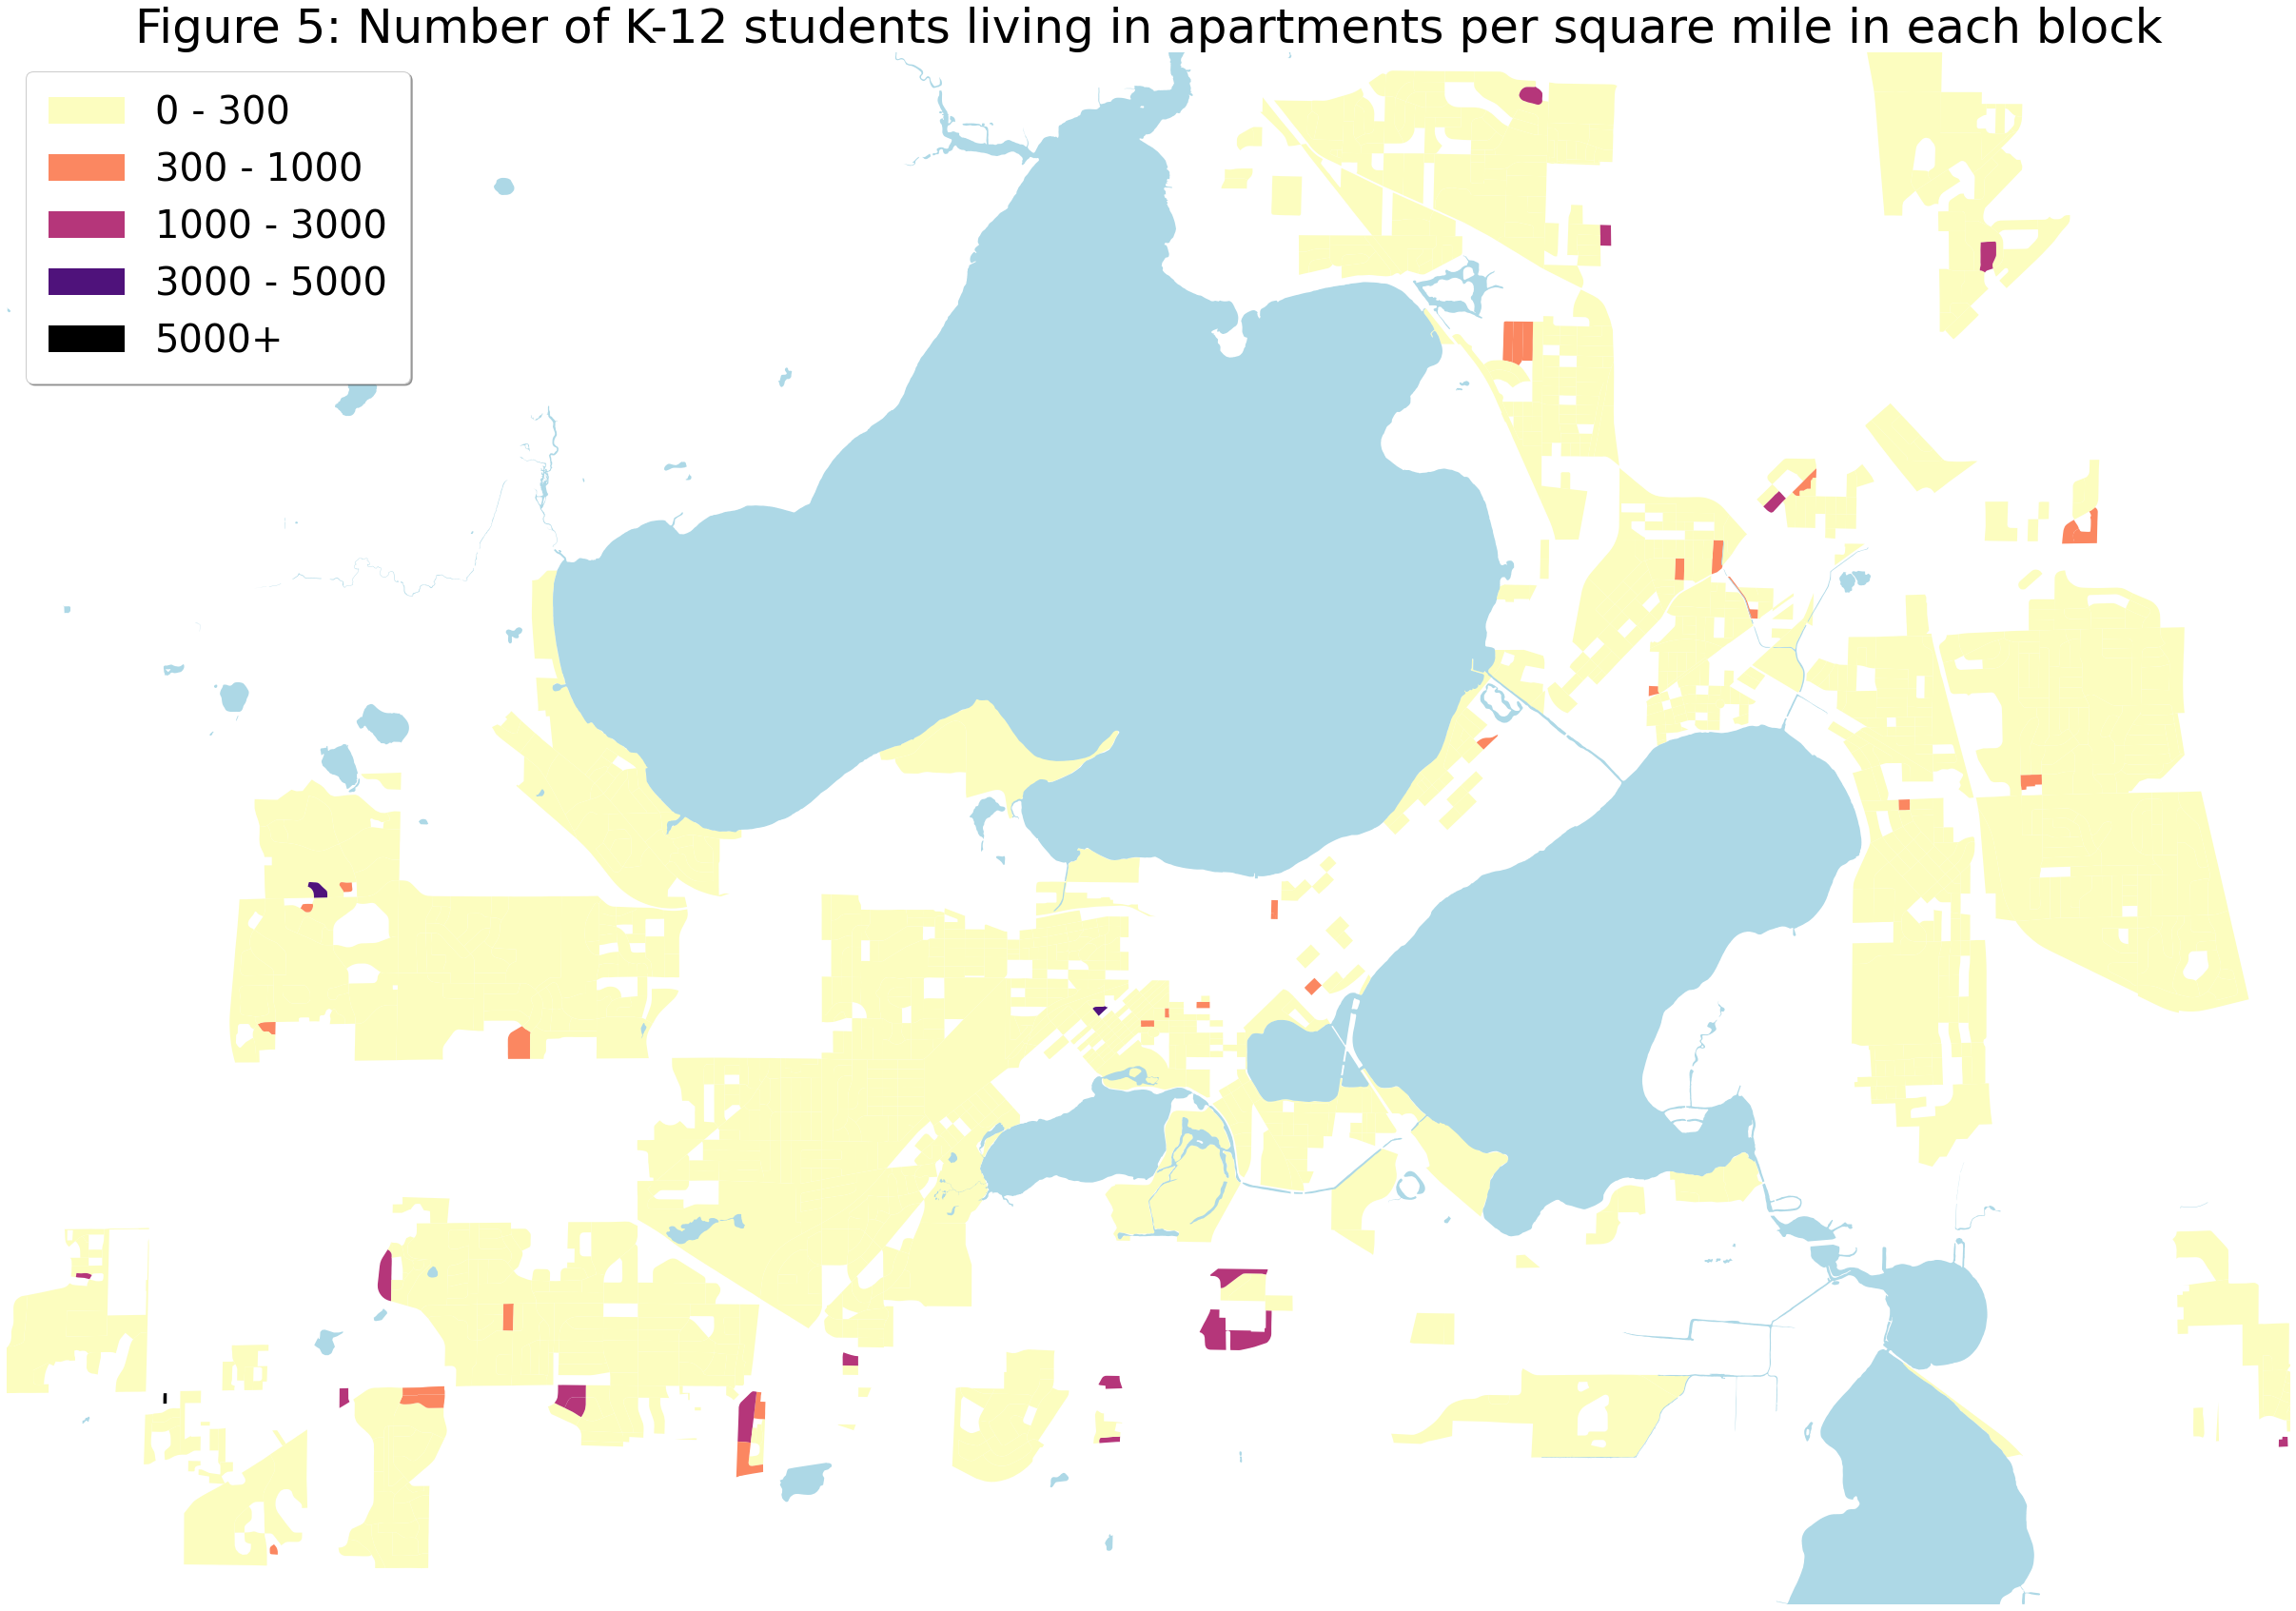

In [21]:

result = gpd.GeoDataFrame(result)
lake_df = lake_df.to_crs(result.crs)
apartment_madison = gpd.sjoin(result, dane, how="right", op="within")
apartment_madison_tmp = apartment_madison[["geometry", "number"]]
apartment_madison_tmp = apartment_madison_tmp.dropna()
ax = apartment_madison_tmp.plot(figsize = (50, 30), legend=True, scheme = 'NaturalBreaks', k = 5, column='number', cmap = 'magma_r')

handles, labels = ax.get_legend_handles_labels()
cmap = plt.get_cmap('magma_r')
bp = mc.NaturalBreaks(apartment_madison_tmp['number'])
bins = bp.bins
bins = np.insert(bins, 0, 0)
LegendElement = [mpatches.Patch(facecolor=cmap(_*0.25), label=f'{int(max(bins[_], 0))} - {int(bins[_+1])}')
                 for _ in range(4)] + [mpatches.Patch(facecolor='black', hatch='', label='5000+')]

ax.legend(handles = LegendElement, loc='upper left', fontsize=40, shadow=True, borderpad=0.6)

lake_df.plot(ax=ax,color="lightblue")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.0125, 43.150])
ax.set_xlim([-89.55, -89.273])
ax.axis('off')
ax.set_title("Figure 5: Number of K-12 students living in apartments per square mile in each block", fontsize = 50)

### The density plot of k12 in other house

In [22]:
result["other_density"] = result["other_density"].astype(int)
number_other = []
for row in result.iterrows():
    pt = row[1]["other_density"]
    if  0 <= pt <= 500:
        number_other.append(500)
    elif 501 <= pt <= 2000:
        number_other.append(2000)
    elif 2001 <= pt <= 5000:
        number_other.append(5000)
    elif 5001 <= pt <= 12000:
        number_other.append(12000)
    elif 12001 <= pt <= 35000:
        number_other.append(35000)
    else:
        print(pt)
        number_other.append(0)
number_other[1377] = 0
result["number_other"] = number_other

Text(0.5, 1.0, 'Figure 4: Number of K-12 students living in non-apartments per square mile in each block')

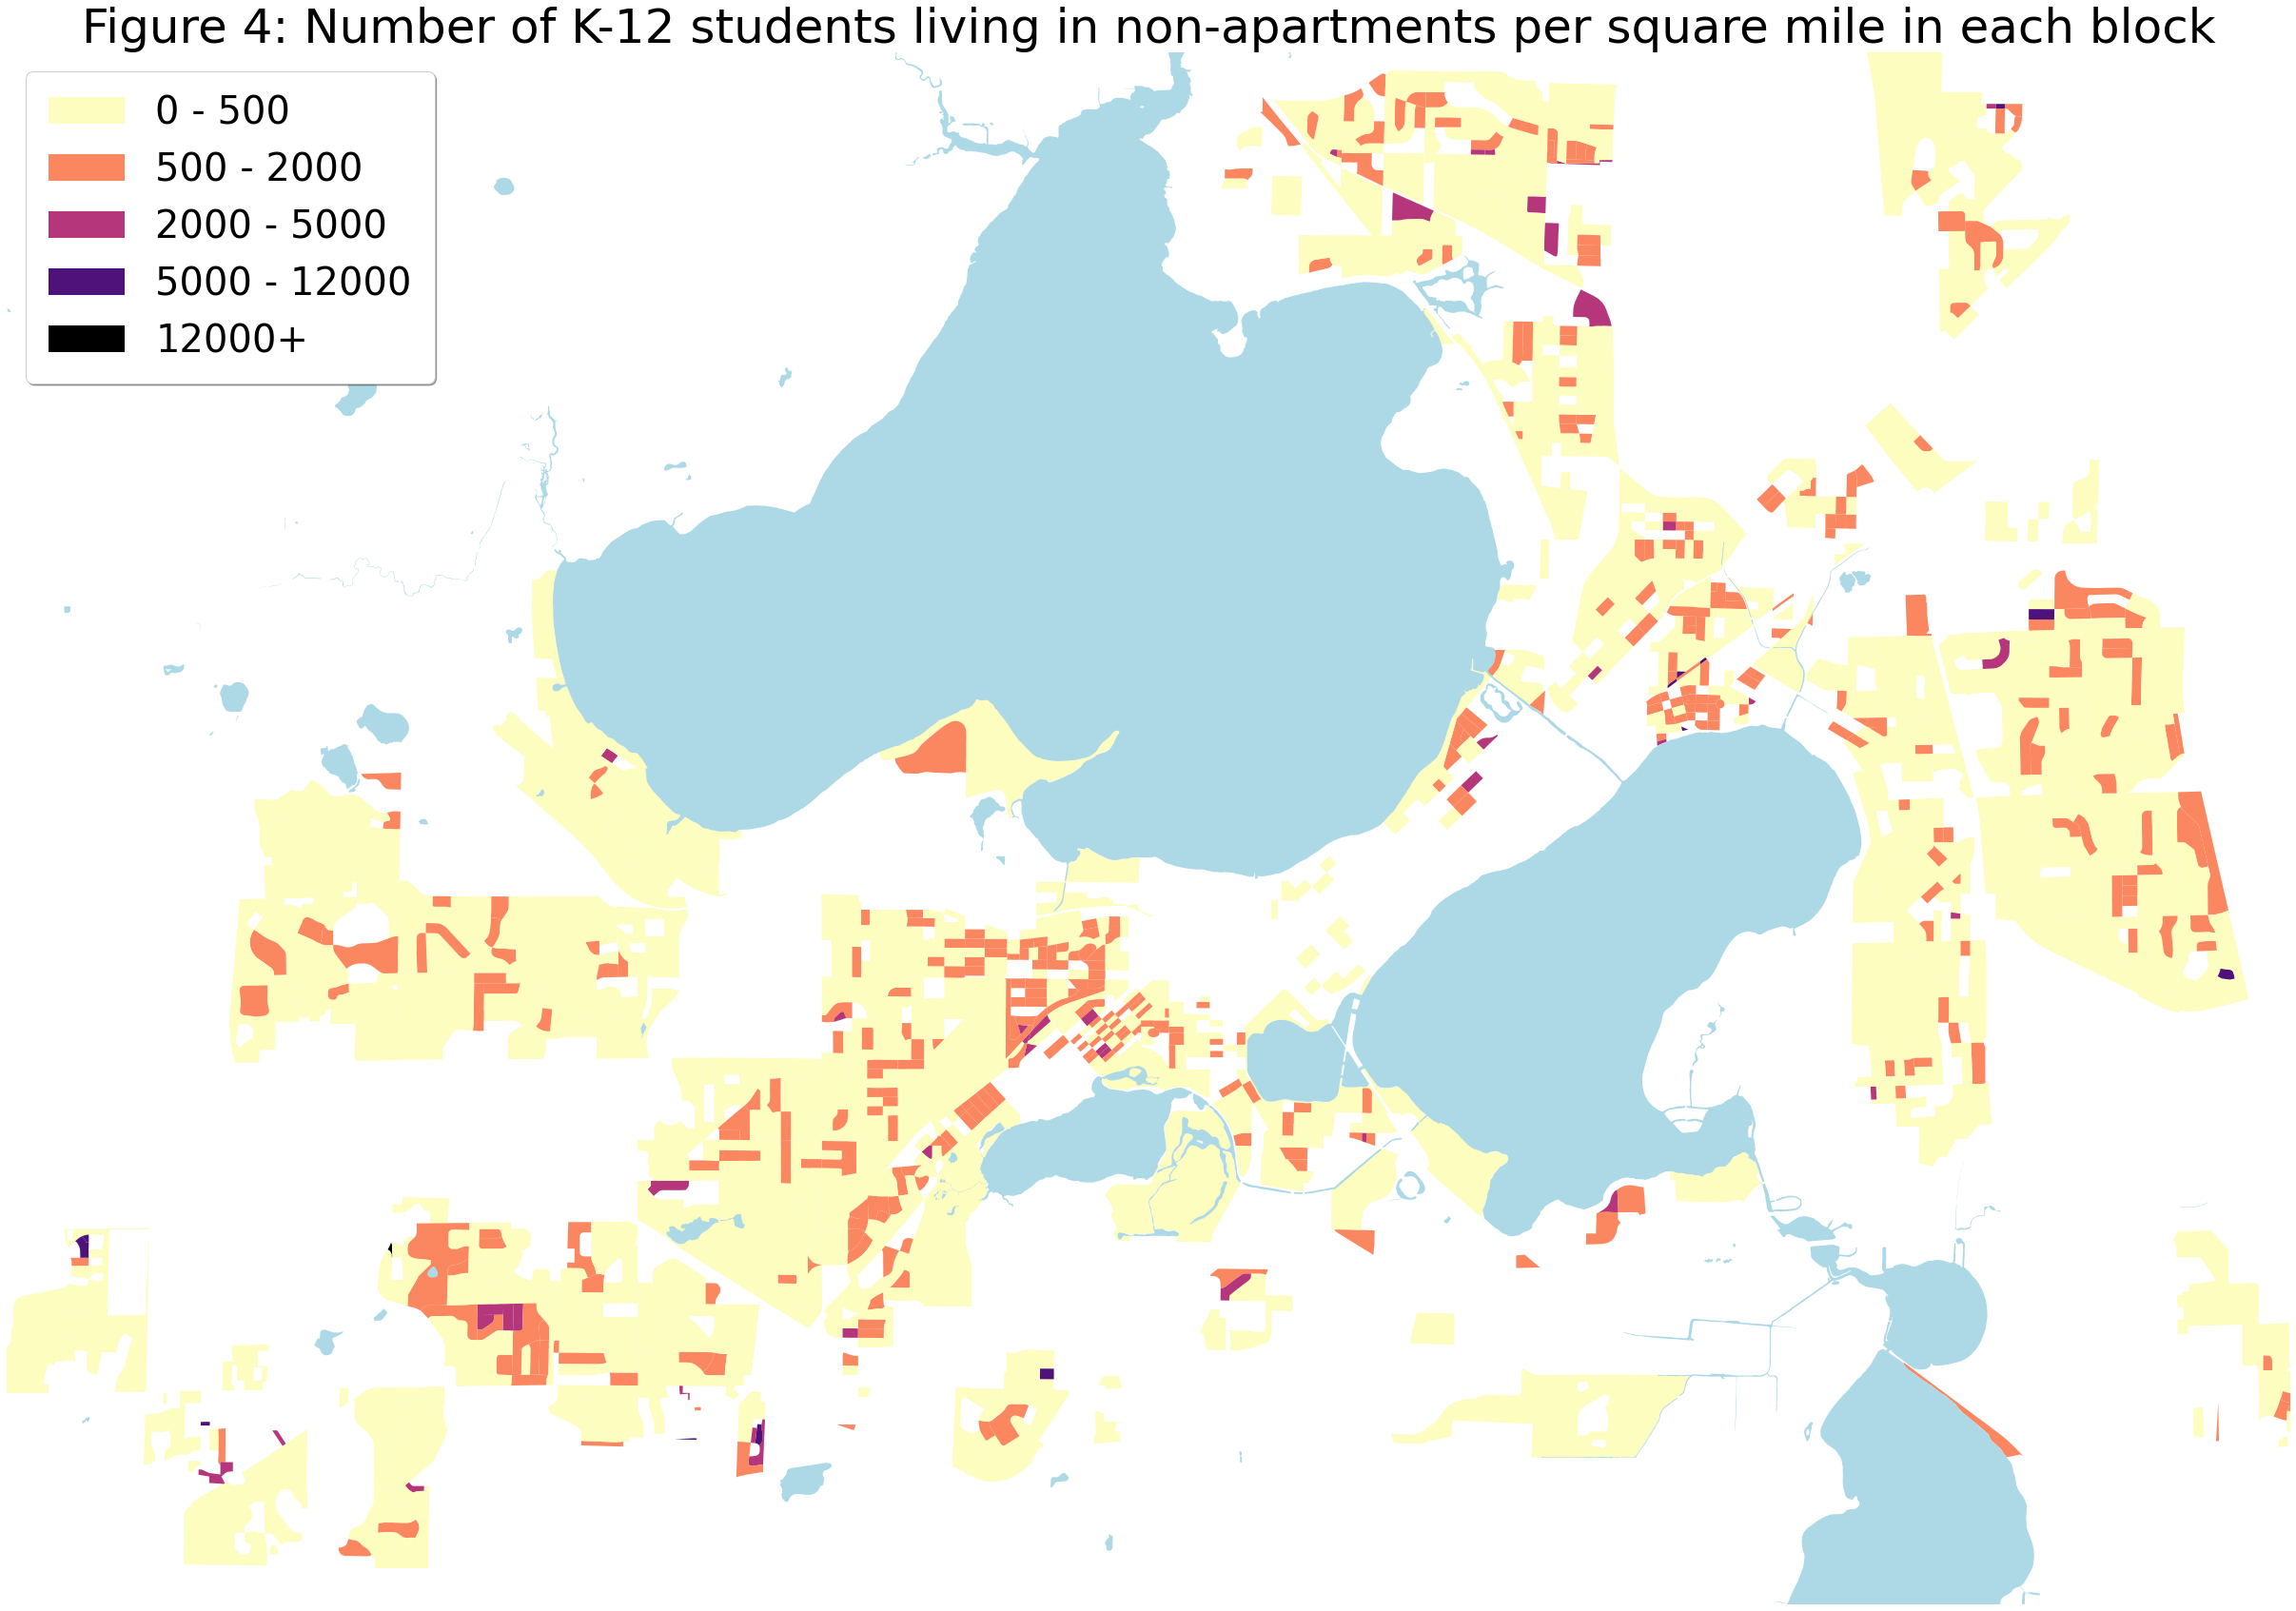

In [23]:
result = gpd.GeoDataFrame(result)
apartment_madison = gpd.sjoin(result, dane, how="right", op="within")
apartment_madison_tmp = apartment_madison[["geometry", "number_other"]]
apartment_madison_tmp = apartment_madison_tmp.dropna()
ax = apartment_madison.plot(figsize = (50, 30), legend=True, scheme = 'NaturalBreaks', k = 5, column='number_other', cmap = 'magma_r')
handles, labels = ax.get_legend_handles_labels()
cmap = plt.get_cmap('magma_r')
bp = mc.NaturalBreaks(apartment_madison_tmp['number_other'])
bins = bp.bins
bins = np.insert(bins, 0, 0)
LegendElement = [mpatches.Patch(facecolor=cmap(_*0.25), label=f'{int(max(bins[_], 0))} - {int(bins[_+1])}')
                 for _ in range(4)] + [mpatches.Patch(facecolor='black', hatch='', label='12000+')]
ax.legend(handles = LegendElement, loc='upper left', fontsize=40, shadow=True, borderpad=0.6)
lake_df.plot(ax=ax,color="lightblue")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.0125, 43.150])
ax.set_xlim([-89.55, -89.273])
ax.axis('off')
ax.set_title("Figure 4: Number of K-12 students living in non-apartments per square mile in each block", fontsize = 50)

## The density plot of k12 in each blocks

In [24]:
result["block_density"] = result['Total_K-12_block'] / result['area']
result["block_density"] = result["block_density"].astype(int)
all_ = []
for row in result.iterrows():
    pt = row[1]["block_density"]
    if  0 <= pt <= 500:
        all_.append(500)
    elif 501 <= pt <= 2000:
        all_.append(2000)
    elif 2001 <= pt <= 5000:
        all_.append(5000)
    elif 5001 <= pt <= 12000:
        all_.append(12000)
    elif 12001 <= pt <= 35000:
        all_.append(35000)
all_[1381] = 0
result["all"] = all_

Text(0.5, 1.0, 'Figure 2: Number of K-12 students in Madison per census block per square mile')

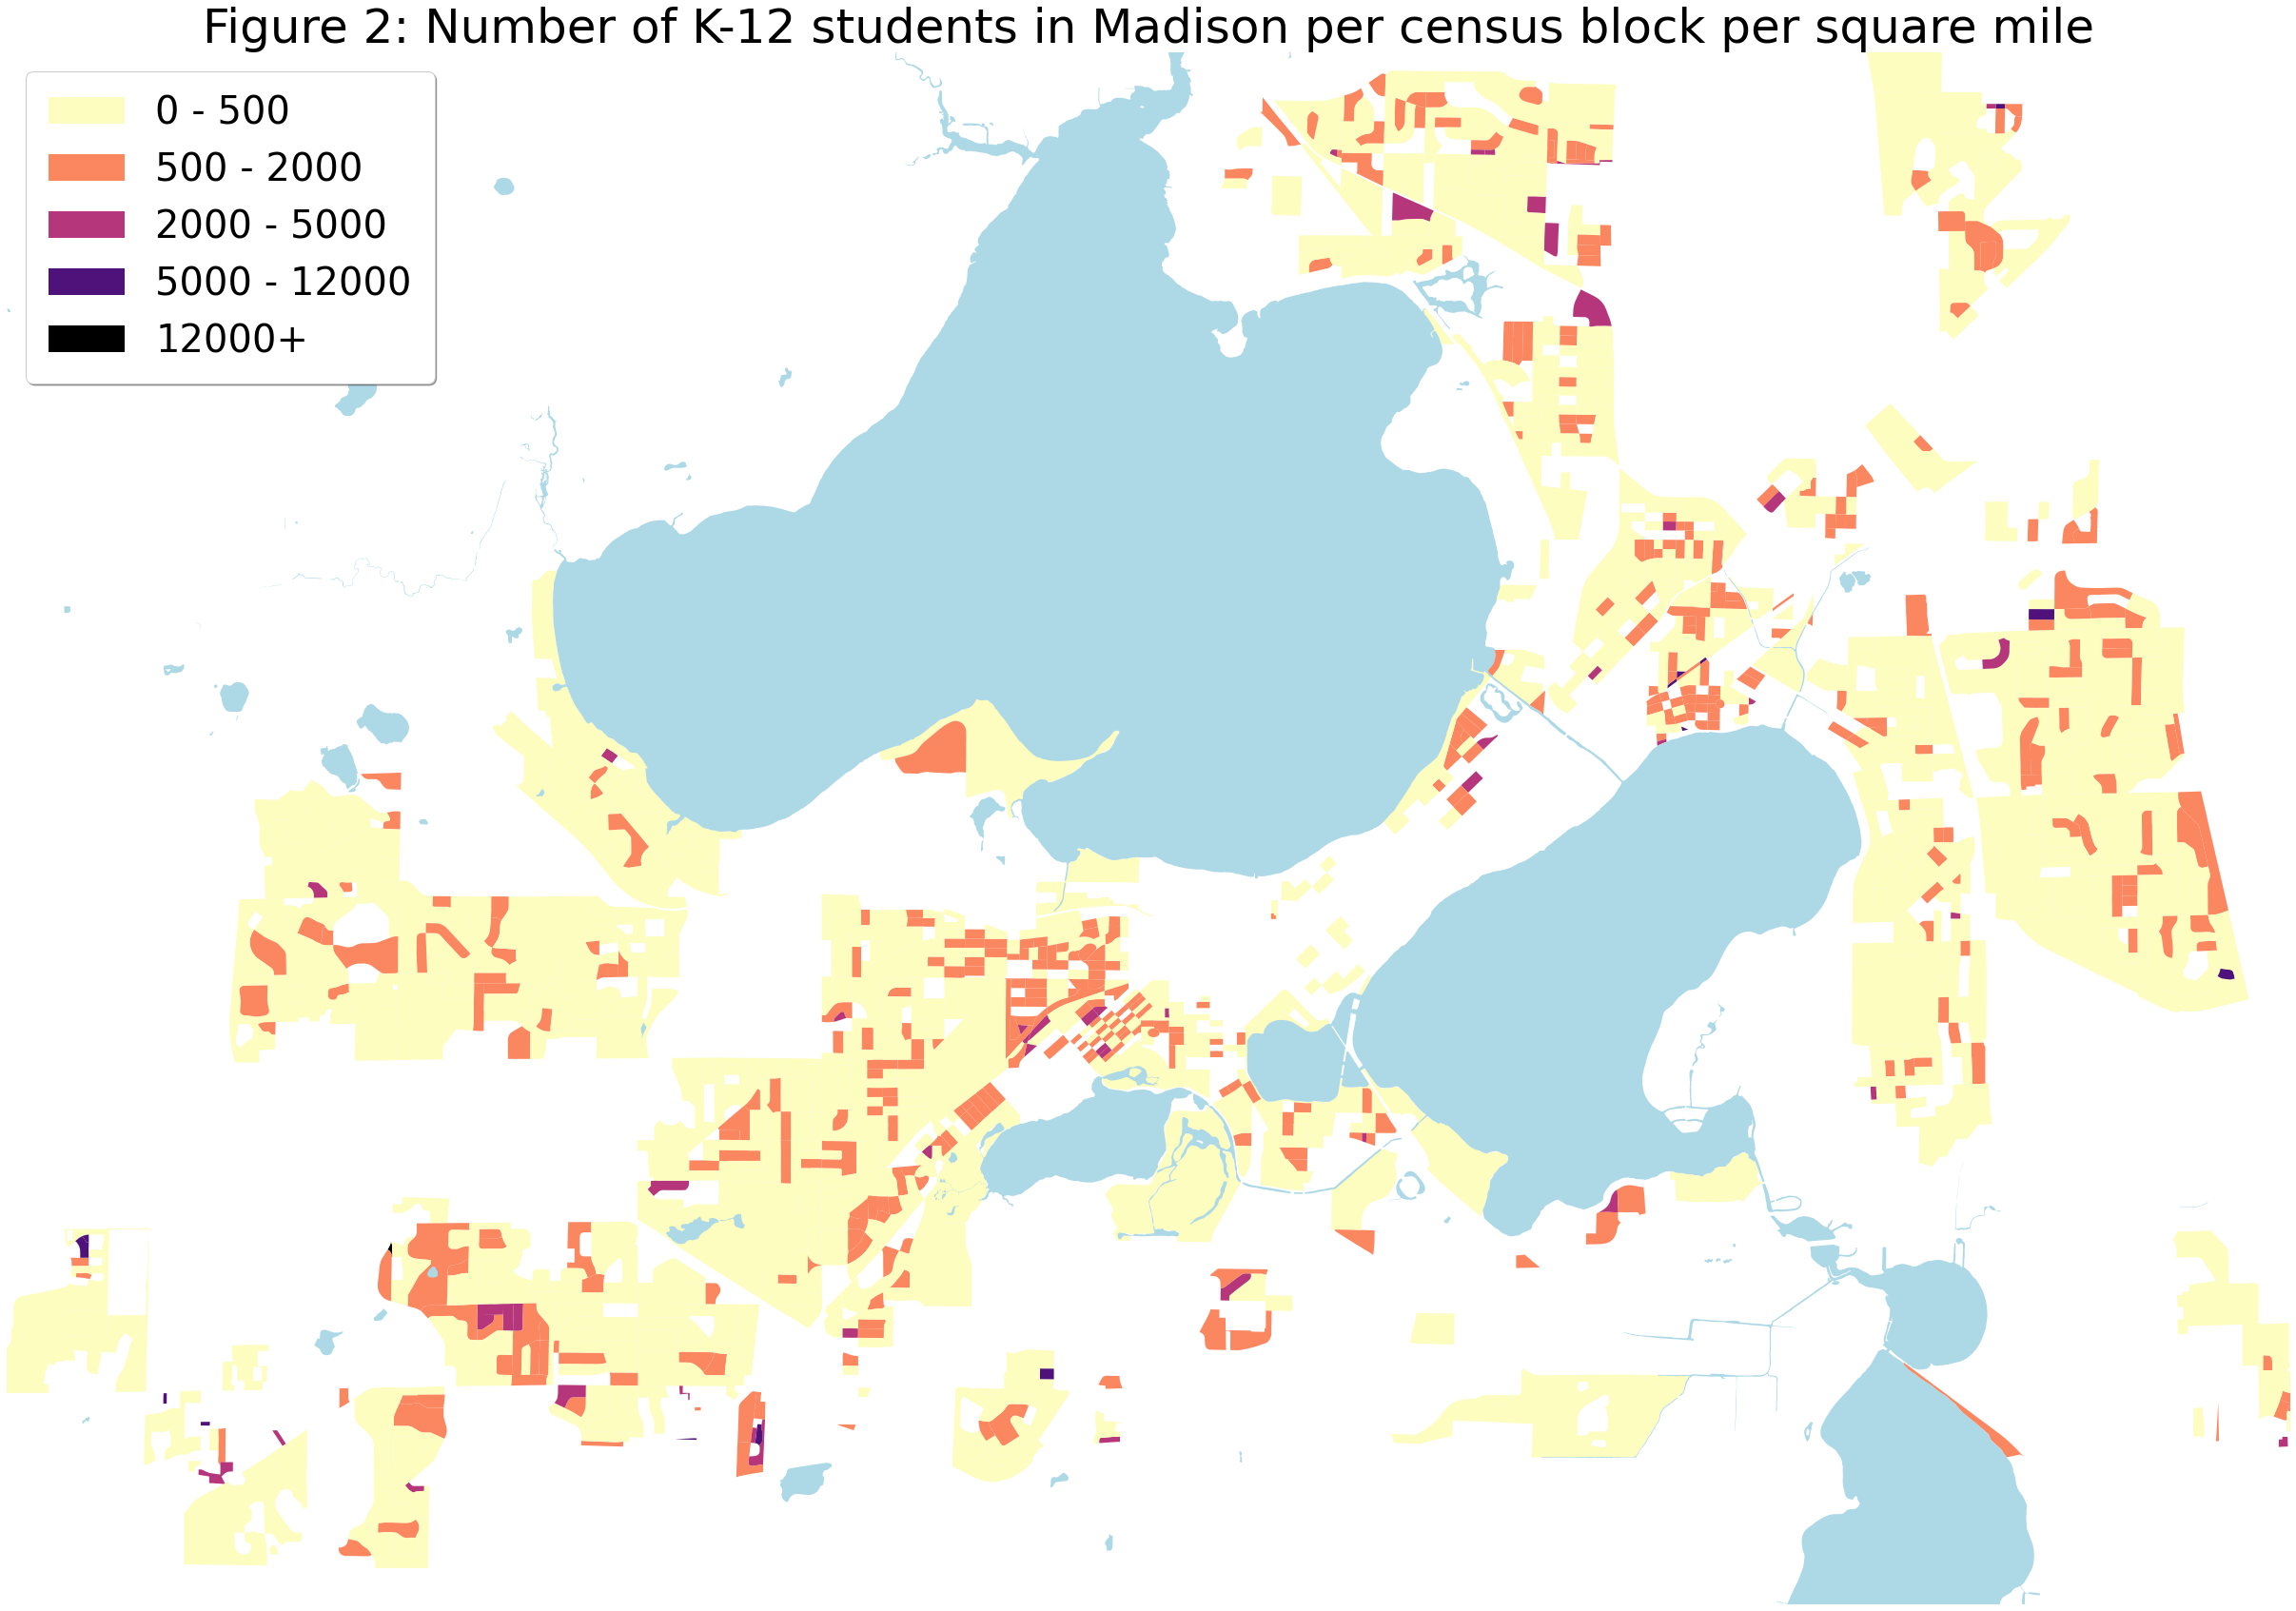

In [25]:

result = gpd.GeoDataFrame(result)
apartment_madison = gpd.sjoin(result, dane, how="right", op="within")
apartment_madison_tmp = apartment_madison[["geometry", "all"]]
apartment_madison_tmp = apartment_madison_tmp.dropna()
ax = apartment_madison.plot(figsize = (50, 30), legend=True, scheme = 'NaturalBreaks', k = 5, column='all', cmap = 'magma_r')
handles, labels = ax.get_legend_handles_labels()
cmap = plt.get_cmap('magma_r')
bp = mc.NaturalBreaks(apartment_madison_tmp['all'])
bins = bp.bins
bins = np.insert(bins, 0, 0)
LegendElement = [mpatches.Patch(facecolor=cmap(_*0.25), label=f'{int(max(bins[_], 0))} - {int(bins[_+1])}')
                 for _ in range(4)] + [mpatches.Patch(facecolor='black', hatch='', label='12000+')]
ax.legend(handles = LegendElement, loc='upper left', fontsize=40, shadow=True, borderpad=0.6)
lake_df.plot(ax=ax,color="lightblue")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.0125, 43.150])
ax.set_xlim([-89.55, -89.273])
ax.axis('off')
ax.set_title("Figure 2: Number of K-12 students in Madison per census block per square mile", fontsize = 50)

In [3]:
data = pd.read_csv("Top70_Apartments_final.csv")
data["#Bedrooms"] = data["#Bedrooms"].astype(int)
data["#K12Estimates"] = data["#K12Estimates"].astype(int)
data

,Address,#Bedrooms,#K12Estimates
0,7240-7484 (even) Old Sauk Rd,298,68
1,2333 Carling Dr,77,43
2,1141-1149 (odd) Petra Pl,64,40
3,4310-4340 (even) Melody Ln & 2402-2502 (even) ...,465,36
4,2330-2358 (even) Allied Dr,64,35
...,...,...,...
65,5817 Raymond Rd,12,4
66,3102 Old Gate Rd,14,4
67,1049&1057 McKenna Blvd,16,4
68,1101&1103&1105 McKenna Blvd Unit H,16,4


In [38]:
# data = data[["Address", "geometry", "Estimateed K-12 students"]]

In [4]:
data["Est children per bedroom"] = data["#K12Estimates"] / data["#Bedrooms"]

In [7]:
# html format
# data.to_csv("Final_result.csv",  index = False)